In [25]:
# Import Libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import geopandas as gpd
import rasterio # Rasters
from shapely.geometry import Point, LineString, shape

# Visualization

import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

import warnings
warnings.filterwarnings('ignore')

In [26]:
# Load plotting data

raster = np.load('template.npy')

trip = gpd.read_file('DoryTrip.geojson').to_crs('EPSG:26915')

In [27]:
# Definitions
    
def six_plot(rast_names, suptitle, with_path = False, res = 300):
    
    # Load necessary data
    
    raster = np.load('template.npy')
    
    trip = gpd.read_file('DoryTrip.geojson').to_crs('EPSG:26915')
    
    f, axs = plt.subplots(2,3, figsize = (24,16))
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1) # Norm for coloration
    
    for i, ax in enumerate(axs.flatten()):
        
        path = os.path.join('5_weights_tests', rast_names[i])
        
        # Load that raster

        rast = rasterio.open(path) # Open

        values = rast.read(1) # Save band

        rast.close() # Close

        # Plot it

        art = ax.pcolormesh(raster[0], raster[1], values.T, norm = norm, shading='auto', cmap = 'magma_r')#, alpha = 0.4) # Plot interpolation
        title = rast_names[i][:-17]

        trip.plot(categorical = True, cmap = 'Dark2',
            # column = 'type', cmap = 'black',
                  # legend = True, 
                  marker = '*', markersize = 200, ax = ax)
        
        # With path
        
        if with_path:
            
            if title[0] != '0': # We don't have paths if no slope...
            
                # Load that raster

                path = os.path.join(os.getcwd(), '6_costpaths', title + '_CostPath.tif')

                rast = rasterio.open(path) # Open

                costpath = rast.read(1) # Save band

                rast.close() # Close

                # Get path coords & Cost

                is_path = np.argwhere(np.rot90(costpath, k=3)==3) # Weird save in Arcpro... Also the numpy mgrid is weird
                x_coords = raster[0].T[0][[x[0] for x in is_path]].flatten()
                y_coords = raster[1][0][[x[1] for x in is_path]].flatten()
                #zip the coordinates into a point object and convert to a GeoData Frame
                geom = LineString([Point(xy) for xy in zip(x_coords, y_coords)])
                path_df = gpd.GeoDataFrame(geometry=[geom], crs = 'EPSG:26915')
                                
                cost = values[~np.isnan(values)].T[is_path].sum()
                
                # Plot
                path_df.plot(ax = ax)
                # ax.pcolormesh(raster[0], raster[1], np.rot90(costpath), shading='auto', cmap = 'Greys', alpha = .3)#, zorder = -1)

                title = title + '\nPath Cost = ' + str(cost)
        
        ax.set_title(title, fontsize = 16) # Add title
        ax.set_axis_off()
    
    
    f.colorbar(art, ax=axs[:, :], location='right', shrink=0.85)
    f.suptitle(suptitle, fontsize = 24)
    # f.tight_layout()
    f.savefig(suptitle+'.png', dpi = res)
    plt.close()

In [28]:
# Visually...

# Get groups of tifs to plot together

file_names = np.array(os.listdir('5_weights_tests'))

# No water # selecting 6 plots

no_water_tifs = file_names[['-0W-' in i for i in file_names]]
no_water_tifs.sort()

no_water_select = no_water_tifs[[0, 3, 5, 7, 9, 1]]

# No Field # selecting 6 plots

no_field_tifs = file_names[['-0F-' in i for i in file_names]]
no_field_tifs.sort()

no_field_select = no_field_tifs[[0, 3, 5, 7, 9, 1]]

# Half Surface # 6 plots

half_slope = file_names[['50S-' in i for i in file_names]]
half_slope.sort()


# Half Water # 6 plots

half_water = file_names[['-50W-' in i for i in file_names]]
half_water.sort()

# Half Field # 6 plots

half_field = file_names[['-50F-' in i for i in file_names]]
half_field.sort()

# Plot groups

plot_gps = [no_water_select, no_field_select, half_slope,
               half_water, half_field]

# Plot Group Names

plot_gp_names = ['No Water', 'No Field', '50 Percent Weighted Slope', '50 Percent Weighted Water', '50 Percent Weighted Field']

In [29]:
for i, plot_gp in enumerate(plot_gps):
    
    title = plot_gp_names[i] + ' Cost Surfaces'
    
    six_plot(plot_gp, title, with_path = True, res = 150)

In [30]:
# Look at all costpaths???

filenames = os.listdir('5_weights_tests')

weights = np.empty([3, len(filenames)], dtype = int)
names = np.empty(len(filenames), dtype = object)
costs = np.empty(len(filenames), dtype = float)
paths = np.empty(len(filenames), dtype = object)

for i, filename in enumerate(filenames):
    
    names[i] = name = filename[:-17]
    weights[0,i] = int(name.split('-')[0][:-1])
    weights[1,i] = int(name.split('-')[1][:-1])
    weights[2,i] = int(name.split('-')[2][:-1])
    
    if name[0] != '0':
        # Load the files

        path = os.path.join(os.getcwd(), '6_costpaths', name + '_CostPath.tif')

        rast = rasterio.open(path) # Open

        costpath = rast.read(1) # Save band

        rast.close() # Close

        path = os.path.join(os.getcwd(), '5_weights_tests', filename)

        rast = rasterio.open(path) # Open

        values = rast.read(1)

        rast.close()

        # Get Cost of path

        is_path = np.argwhere(np.rot90(costpath, k=3)==3) # Weird save in Arcpro... Or the mgrid is weird...
        costs[i] = values[~np.isnan(values)].T[is_path].sum()

        x_coords = raster[0].T[0][[x[0] for x in is_path]].flatten()
        y_coords = raster[1][0][[x[1] for x in is_path]].flatten()

        #zip the coordinates into a point object and convert to a GeoData Frame
        paths[i] = LineString([Point(xy) for xy in zip(x_coords, y_coords)])

In [31]:
# Only 18 unique least cost path...

lss = []
for path in paths[np.argwhere(paths != None)]:
    ls = path[0]
    if ls not in lss:
        lss += [ls]
        
len(lss)

18

In [32]:
# Make into gdf

columns = ['S_weight', 'W_weight', 'F_weight']

paths_df = gpd.GeoDataFrame(weights.T,
                            columns = columns, geometry = paths, crs = 'EPSG:26915')


paths_df['Name'] = names
paths_df['Cost'] = costs



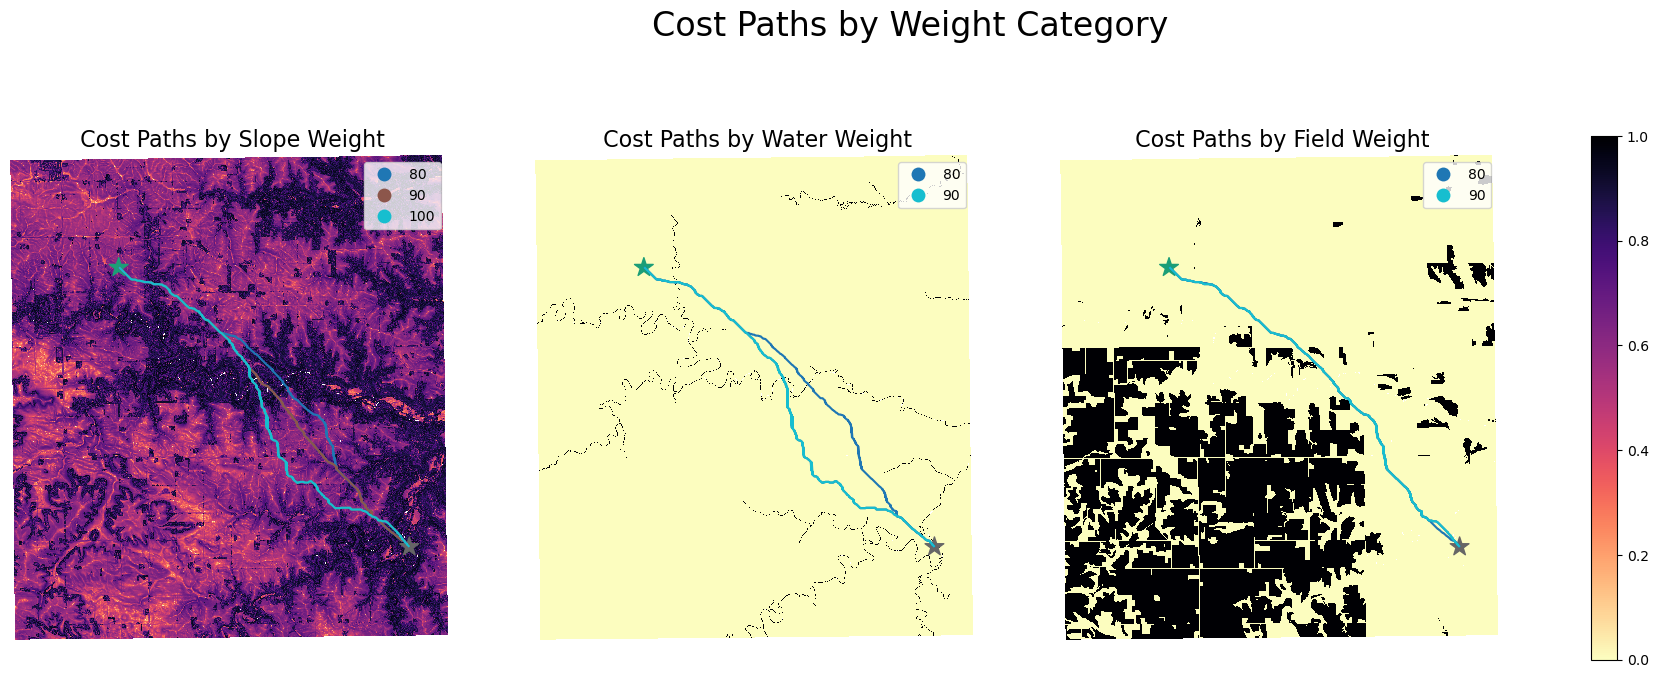

In [33]:
# Plot paths by color for each weight over each surface

plot_gp = ['100S-0W-0F-Cost_Surface.tif',
           '0S-100W-0F-Cost_Surface.tif',
           '0S-0W-100F-Cost_Surface.tif']

category = ['Slope', 'Water', 'Field']

f, axs = plt.subplots(1,3, figsize = (24,8))

norm = mpl.colors.Normalize(vmin=0, vmax=1) # Norm for coloration

# cmap = 
    
for i, ax in enumerate(axs.flatten()):

    path = os.path.join('5_weights_tests', plot_gp[i])

    # Load that raster

    rast = rasterio.open(path) # Open

    values = rast.read(1) # Save band

    rast.close() # Close

    # Plot it
    

    art = ax.pcolormesh(raster[0], raster[1], values.T, norm = norm, shading='auto', cmap = 'magma_r')#, alpha = 0.4) # Plot interpolation
    
    column_name = category[i][0] + '_weight'
    # avg_cost = paths_df[paths_df[column_name] > 
    
    
    df_to_plot = paths_df[paths_df[column_name]>70].dropna()
    # Plot
    df_to_plot.sort_values(by=column_name,
                           ascending = True).reset_index().plot(column = column_name, 
                                      categorical = True, 
                                      cmap = 'tab10',
                                      legend = True,
                                      ax = ax)
    # ax.pcolormesh(raster[0], raster[1], np.rot90(costpath), shading='auto', cmap = 'Greys', alpha = .3)#, zorder = -1)
    
    title = ' Cost Paths by ' + category[i] + ' Weight'
    
    ax.set_title(title, fontsize = 16) # Add title
    ax.set_axis_off()

    trip.plot(categorical = True, cmap = 'Dark2',
        # column = 'type', cmap = 'black',
              # legend = True, 
              marker = '*', markersize = 200, ax = ax)



f.colorbar(art, ax=axs[:], location='right', shrink=0.85)
f.suptitle('Cost Paths by Weight Category', fontsize = 24)
# f.tight_layout()
f.savefig('Cost Paths by Weight Category.png', dpi = 150)
plt.show()


<AxesSubplot: >

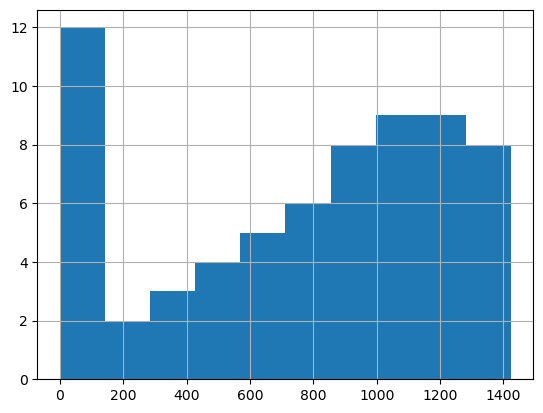

In [34]:
paths_df[paths_df.Cost != 0].Cost.hist()

In [35]:
# Seasonal Optimals

plot_gp = ['20S-40W-40F-Cost_Surface.tif',
           '30S-40W-30F-Cost_Surface.tif',
           '50S-40W-10F-Cost_Surface.tif',
           '60S-40W-0F-Cost_Surface.tif']

seasons = ['Spring', 'Summer', 'Fall', 'Winter']

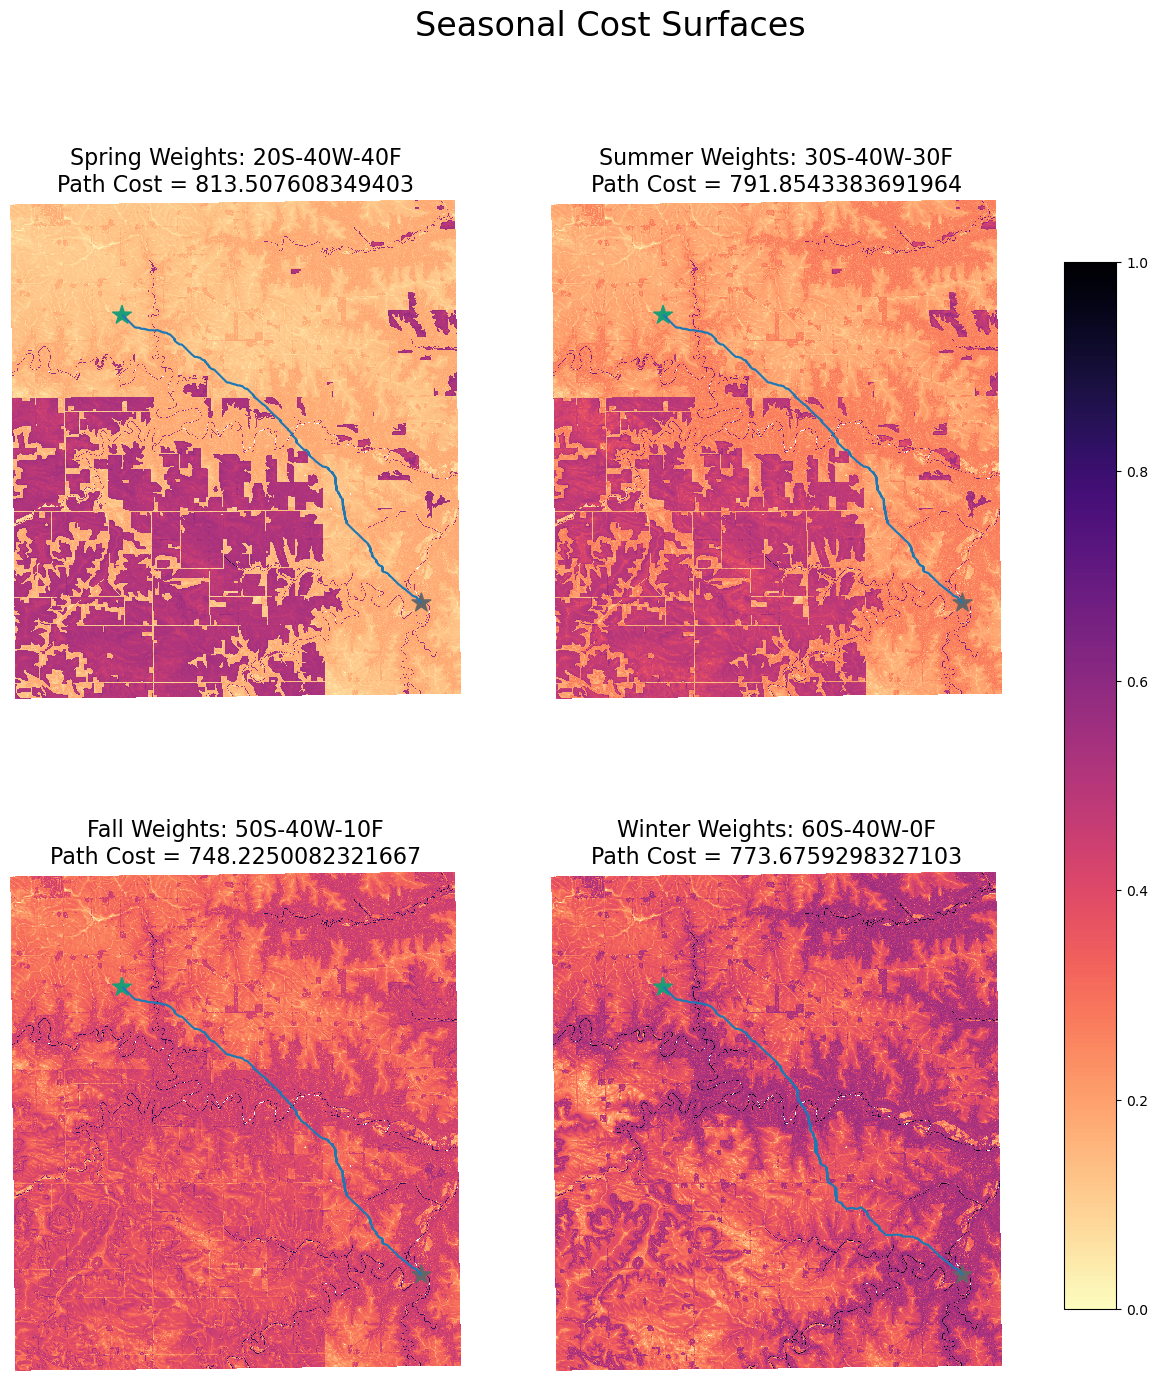

In [36]:
f, axs = plt.subplots(2,2, figsize = (16,16))

norm = mpl.colors.Normalize(vmin=0, vmax=1) # Norm for coloration
    
for i, ax in enumerate(axs.flatten()):

    path = os.path.join('5_weights_tests', plot_gp[i])

    # Load that raster

    rast = rasterio.open(path) # Open

    values = rast.read(1) # Save band

    rast.close() # Close

    # Plot it
    

    art = ax.pcolormesh(raster[0], raster[1], values.T, norm = norm, shading='auto', cmap = 'magma_r')#, alpha = 0.4) # Plot interpolation
    
    # Load that raster (for lease cost path)

    path = os.path.join(os.getcwd(), '6_costpaths', plot_gp[i][:-17] + '_CostPath.tif')

    rast = rasterio.open(path) # Open

    costpath = rast.read(1) # Save band

    rast.close() # Close

    # Get path coords & Cost

    is_path = np.argwhere(np.rot90(costpath, k=3)==3) # Weird save in Arcpro... Also the numpy mgrid is weird
    x_coords = raster[0].T[0][[x[0] for x in is_path]].flatten()
    y_coords = raster[1][0][[x[1] for x in is_path]].flatten()
    #zip the coordinates into a point object and convert to a GeoData Frame
    geom = LineString([Point(xy) for xy in zip(x_coords, y_coords)])
    path_df = gpd.GeoDataFrame(geometry=[geom], crs = 'EPSG:26915')

    cost = values[~np.isnan(values)].T[is_path].sum()

    # Plot
    path_df.plot(ax = ax)
    # ax.pcolormesh(raster[0], raster[1], np.rot90(costpath), shading='auto', cmap = 'Greys', alpha = .3)#, zorder = -1)
    
    title = seasons[i] + ' Weights: ' + plot_gp[i][:-17]
    title = title + '\nPath Cost = ' + str(cost)
    
    ax.set_title(title, fontsize = 16) # Add title
    ax.set_axis_off()

    trip.plot(categorical = True, cmap = 'Dark2',
        # column = 'type', cmap = 'black',
              # legend = True, 
              marker = '*', markersize = 200, ax = ax)



f.colorbar(art, ax=axs[:, :], location='right', shrink=0.85)
f.suptitle('Seasonal Cost Surfaces', fontsize = 24)
# f.tight_layout()
f.savefig('Seasonal Cost Surfaces.png', dpi = 300)
plt.show()